In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import torch#, time
import torch.nn as nn
device = torch.device("cpu")# torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.preprocessing import OneHotEncoder
import matplotlib.animation as animation
from IPython.display import HTML

### (Re-) Implementation of classic Graph Convolutional Network (GCN) using pytorch.
In this example i've implemented classic node-level embedding/aggregation (https://arxiv.org/pdf/1609.02907.pdf).

Problem is taken from https://bagheri365.github.io/blog/Graph-Convolutional-Networks-(GCNs)-from-Scratch, where node classification is performed.

**Derivation is explained in GNN_Convolution__notes.ipynb**

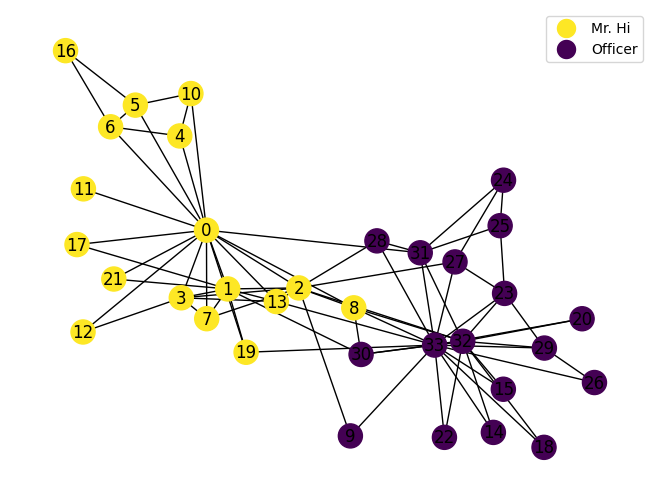

In [2]:
G = nx.karate_club_graph()
np.random.seed(69)
cmap = plt.get_cmap('viridis')
pos = nx.spring_layout(G)
node_color = np.array([1 if c == 'Mr. Hi' else 0 for n,c in G.nodes(data='club')])
node_color_rgba = cmap(255*node_color)
nx.draw(G, pos=pos, with_labels=True, node_color=node_color_rgba)

# Create a custom legend
legend_labels = ['Mr. Hi', 'Officer']
legend_colors = [cmap(255), cmap(0)]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15, label=label) 
                  for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, loc='upper right');

***
Graph shows a Zachary's karate club social relations - nodes are club member.

After some event club is is split into two clubs with new leaders 'Mr. Hi' and 'Officer' (nodes 0 and 32).

Social relations between club members before split event are recorded as edges.

We know which club each member joined after split, we mark this membership by 0 or 1 (hot encoded).

Task is: given we only know who are new club leaders, determine likely membership status of other people from their prior social interactions (graph edges).

This means that task is semi-supervised, only part of information is given. Its calculated via Cross Entropy Loss.

In addition, Laplacian regularization term is added. Its not crystal clear what it does.
***

* $A$ - adjacency matrix $(N_{nodes},N_{nodes})$
* $D$ - degree matrix $(N_{nodes},N_{nodes})$
* $H$ - feature matrix $(N_{nodes},N_{feat})$. row- a feature

$$ H = 
\begin{bmatrix}
\vec{h}_1 & \vec{h}_2 &  \dots & \vec{h}_n
\end{bmatrix}^T
$$
GCN layer is as follows:
$$H^{l+1} = \sigma( D^{-\frac{1}{2}} \tilde A D^{-\frac{1}{2}} H^l W_h + \vec{b_h})$$
$$ \tilde A = A + I $$ 
$$ A_{full} = D^{-\frac{1}{2}} \tilde A D^{-\frac{1}{2}} $$ 

* shape $A_{full}$ - $(N_{nodes},N_{nodes})$


$A_{full}$ does agglomeration of features in $H^l$.
$$H_{agg}^l = A_{full}H^l$$
* shape $H_{agg}^l $ - $(N_{nodes},N_{feat})$
$$H^{l+1} = \sigma( H_{agg}^l W_h + \vec{b_h})$$
$W_h$ is a linear map that embeds rows of $H^l$ into latent vector (hidden state) of shape  `hs`.<br>
$W_h$ shape is $(N_{feat},N_{hs})$;
$\vec{b_h}$ is a bias of shape $(N_{hs})$

We can use pytorch torch.nn.Linear(), which solves 
$$y = x W^T + b$$
Where shapes of fields are:
* x - $(*, f_{in})$;
* $W^T$ - $(f_{in}, f_{out})$;
* b - $f_{out}$;
* y - $(*, f_{out})$

Which matches our problem.

* Generate  $H_{agg}^{l = 0}$

In [3]:
A = nx.adjacency_matrix(G, weight=None)
A_tilde = A + np.eye(*A.shape);display(A_tilde)
node_degrees = [degree for node, degree in G.degree]
D_inv = np.diag(1/np.sqrt(node_degrees))
A_full = D_inv @ A_tilde @ D_inv; A_full.shape
L = torch.tensor(nx.laplacian_matrix(G, weight=None).todense(), dtype=torch.float);L

array([[1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

tensor([[16., -1., -1.,  ..., -1.,  0.,  0.],
        [-1.,  9., -1.,  ...,  0.,  0.,  0.],
        [-1., -1., 10.,  ...,  0., -1.,  0.],
        ...,
        [-1.,  0.,  0.,  ...,  6., -1., -1.],
        [ 0.,  0., -1.,  ..., -1., 12., -1.],
        [ 0.,  0.,  0.,  ..., -1., -1., 17.]])

input $H^{l = 0}$ into layer 1 encodes ${ID}_i : i \in [0,1,\dots, 33]$ of each node.

$$ H = 
\begin{bmatrix}
\vec{h}_1 & \vec{h}_2 &  \dots & \vec{h}_n
\end{bmatrix}^T
$$

So just rows of identity matrix N nodes by N features.
***

GCN will do aggregation on in two steps:
1. aggregate initial node IDs one-hot index (*, 34) and map embeddings to (*, 4)
2. aggregate embeddings and map them to (*,2)

Final embeddings should represent one-hot vector which tags 'club'- ether 0: 'Mr. Hi' or 1: 'Officer'

Loss is two-fold:
1. suprevised loss on masked club membership
2. Frobenius norm regularization
***

In [4]:
N_FEATURES, N_NODES = A.shape
HIDDEN = 4
OUT_FEATURES = 2

class net(nn.Module):
    def __init__(self, H0, A):
        super(net, self).__init__()
        self.H0     = torch.tensor(H0, dtype=torch.float, requires_grad=False, device=device)
        self.A      = torch.tensor(A,  dtype=torch.float, requires_grad=False, device=device)
        self.l1     = nn.Linear(N_FEATURES, HIDDEN     , bias=False, device=device)
        self.l2     = nn.Linear(HIDDEN, OUT_FEATURES   , bias=False, device=device)
        self.activation = nn.ReLU()
        self.activation2 = nn.Softmax(dim = 1)

    def forward(self):
        # layer 1
        y = self.A @ self.H0
        y = self.l1(y)
        y = self.activation(y)
        # layer 2
        y = self.A @ y
        y = self.l2(y)
        y = self.activation2(y)
        #y = torch.argmax(y, dim=1)
        return y
    
H_0 = np.eye(*A.shape)

model = net(H_0, A_full)
model

net(
  (l1): Linear(in_features=34, out_features=4, bias=False)
  (l2): Linear(in_features=4, out_features=2, bias=False)
  (activation): ReLU()
  (activation2): Softmax(dim=1)
)

* Encode club IDs into 2 dim vector;
* create a mask for semi-supervised loss.

In [5]:
Y_train = OneHotEncoder(categories='auto').fit_transform(node_color.reshape(-1, 1))
Y_train = torch.tensor(Y_train.todense());
print(Y_train.shape)
mask = torch.zeros(N_NODES, 1, requires_grad=False, device=device)
mask[[0,33]] = 1

torch.Size([34, 2])


* define a loss function like in a paper. Its row-wise cross entropy. IDK how to make pytorch version work

In [6]:
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(MaskedCrossEntropyLoss, self).__init__()

    def forward(self, Z, targets, mask):
        Z_masked, tar_masked = Z*mask, targets*mask     # can subset instead of multiply, nn.CrossEntropyLoss will work.
        #ce_loss = nn.CrossEntropyLoss(reduction='none')(inp_masked, tar_masked)  
        return -torch.sum(tar_masked * torch.log(Z_masked+0.0001))
    

### Define a train function
* loss 1 - cross entropy
* loss 2 - Laplace regularization + Frobenius norm

In [7]:
optimizer  = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay=5e-4)
criterion = MaskedCrossEntropyLoss()
REGULARIZATION = 0.01
def train():
    model.train()
    optimizer.zero_grad()
    Z = model()
    loss1 = criterion(Z = Z, targets = Y_train, mask=mask)
    loss2 = torch.norm(torch.transpose(Z,0,1) @ L @ Z, p = 'fro')
    loss = loss1 + REGULARIZATION*loss2
    loss.backward()
    optimizer.step()
    return loss, Z.detach().cpu()


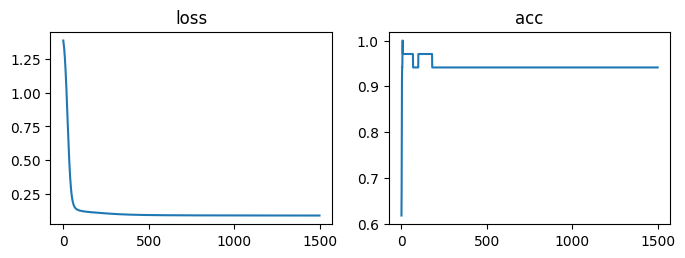

In [8]:
ITERS = 1500
fig, ax = plt.subplots(1,2, figsize = (8,2.5))
loss = torch.zeros(ITERS)
acc = torch.zeros(ITERS)
color_true = torch.tensor(node_color, dtype=torch.float)

REPORT_STEP = 10
save_iters  = torch.arange(0, ITERS + 1, REPORT_STEP)
save_Z      = torch.zeros(len(save_iters), N_NODES, OUT_FEATURES).cpu()
save_color  = torch.zeros(len(save_iters), N_NODES).cpu()
si = 0
for i in range(ITERS):
    l, Z            = train()
    loss[i]         = l
    color_predict   = torch.argmax(Z, dim= 1)    #pick highest prob for each node
    # compare to club marking abs diff. mean shows percentage of failed classifications
    acc[i] = 1 - torch.mean(torch.abs(color_predict-color_true))
    if i in save_iters:
        save_Z[si] = Z.detach().cpu()
        save_color[si] = color_predict.detach().cpu()
        si += 1

ax[0].plot(loss.cpu().detach().numpy())
ax[1].plot(acc.cpu().detach().numpy())
ax[1].set_title('acc')
ax[0].set_title('loss');

* test

In [9]:
with torch.no_grad():
  Z = model()
  zz = torch.argmax(Z, dim= 1)
  print(torch.abs(zz-torch.tensor(node_color, dtype=torch.float)))
  print(1- torch.mean(torch.abs(zz-torch.tensor(node_color, dtype=torch.float))))


tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor(0.9412)


Define latent space plot for animations

In [10]:
nodes = list(G.nodes())

colors_true = [cmap(k) for k in color_true]
fig= plt.figure(dpi=150)
ax = fig.subplots()
def plot_results(iter):
    embeddings  = save_Z
    colors      = save_color
    ax.cla()
    #ax.axis('off')
    ax.set_title(f'Karate club network node embeddings for epoch: {iter:<{len(str(ITERS))}}') 
    pos = {n:xy.numpy() for n,xy in zip(nodes, embeddings[iter])}
    nx.draw_networkx_nodes(           G, pos, ax = ax, cmap=cmap, node_color=colors[iter], edgecolors= colors_true, linewidths=3)
    nx.draw_networkx_labels(          G, pos, ax = ax, font_color='red', font_size= 15)
    nx.draw_networkx_edges(           G, pos, ax = ax)
    #plt.close()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('feature 1')
    ax.set_ylabel('feature 2')
    #print(pos)
    #plt.show()
    plt.close()
plt.close()
#plot_results(0)


In [11]:
plot_dur = 5    # seconds
num_frames = len(save_Z)
delay = plot_dur/num_frames*1000
anim = animation.FuncAnimation(fig, plot_results, frames=num_frames, interval=delay)
HTML(anim.to_html5_video())